## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 31.8 s, sys: 262 ms, total: 32.1 s
Wall time: 32.2 s


In [4]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_4'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
p_aug = 0.0

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Sat Jan 11 17:54:50 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


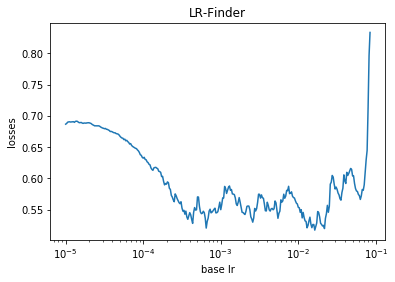

epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50398 - spearmanr 0.25419
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.467 - spearmanr 0.39666


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.39666
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45282 - spearmanr 0.40473
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.45206 - spearmanr 0.41632
best model: epoch 1 - 0.41632
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42764 - spearmanr 0.47401
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.45096 - spearmanr 0.4202
best model: epoch 2 - 0.4202
TRAINING END: Best score achieved on epoch 2 - 0.42020
Starting inference for model: checkpoints/siamese_bert_4_fold_1_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_1_best.pth



Fold 2 started at Sat Jan 11 18:25:34 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50323 - spearmanr 0.25415
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.46642 - spearmanr 0.39282
best model: epoch 0 - 0.39282
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45229 - spearmanr 0.40654
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.45335 - spearmanr 0.42264
best model: epoch 1 - 0.42264
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42668 - spearmanr 0.47564
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.45432 - spearmanr 0.42229
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 1 - 0.42264
Starting inference for model: checkpoints/siamese_bert_4_fold_2_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_2_best.pth



Fold 3 started at Sat Jan 11 18:55:20 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50312 - spearmanr 0.25814
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.46812 - spearmanr 0.36651
best model: epoch 0 - 0.36651
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45226 - spearmanr 0.40652
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.46118 - spearmanr 0.39528
best model: epoch 1 - 0.39528
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42649 - spearmanr 0.47683
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.45962 - spearmanr 0.39984
best model: epoch 2 - 0.39984
TRAINING END: Best score achieved on epoch 2 - 0.39984
Starting inference for model: checkpoints/siamese_bert_4_fold_3_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_3_best.pth



Fold 4 started at Sat Jan 11 19:25:00 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50356 - spearmanr 0.25943
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.46792 - spearmanr 0.3641
best model: epoch 0 - 0.3641
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45284 - spearmanr 0.40619
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.45548 - spearmanr 0.39875
best model: epoch 1 - 0.39875
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42661 - spearmanr 0.47756
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.45371 - spearmanr 0.40119
best model: epoch 2 - 0.40119
TRAINING END: Best score achieved on epoch 2 - 0.40119
Starting inference for model: checkpoints/siamese_bert_4_fold_4_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_4_best.pth



Fold 5 started at Sat Jan 11 19:54:44 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50405 - spearmanr 0.25569
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.4675 - spearmanr 0.37001
best model: epoch 0 - 0.37001
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45259 - spearmanr 0.40927
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.45333 - spearmanr 0.39606
best model: epoch 1 - 0.39606
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42627 - spearmanr 0.47896
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.45297 - spearmanr 0.4006
best model: epoch 2 - 0.4006
TRAINING END: Best score achieved on epoch 2 - 0.40060
Starting inference for model: checkpoints/siamese_bert_4_fold_5_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_5_best.pth



Fold 6 started at Sat Jan 11 20:24:24 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50285 - spearmanr 0.26142
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.4663 - spearmanr 0.36776
best model: epoch 0 - 0.36776
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45274 - spearmanr 0.40904
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.4501 - spearmanr 0.39878
best model: epoch 1 - 0.39878
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42669 - spearmanr 0.47832
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.44902 - spearmanr 0.39981
best model: epoch 2 - 0.39981
TRAINING END: Best score achieved on epoch 2 - 0.39981
Starting inference for model: checkpoints/siamese_bert_4_fold_6_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_6_best.pth



Fold 7 started at Sat Jan 11 20:54:12 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50335 - spearmanr 0.25657
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.47198 - spearmanr 0.37476
best model: epoch 0 - 0.37476
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45205 - spearmanr 0.40794
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.45646 - spearmanr 0.41023
best model: epoch 1 - 0.41023
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42627 - spearmanr 0.47632
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.45609 - spearmanr 0.42133
best model: epoch 2 - 0.42133
TRAINING END: Best score achieved on epoch 2 - 0.42133
Starting inference for model: checkpoints/siamese_bert_4_fold_7_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_7_best.pth



Fold 8 started at Sat Jan 11 21:23:27 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50308 - spearmanr 0.25335
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.4796 - spearmanr 0.38061
best model: epoch 0 - 0.38061
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45149 - spearmanr 0.40686
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.46339 - spearmanr 0.41371
best model: epoch 1 - 0.41371
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42685 - spearmanr 0.47391
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.46167 - spearmanr 0.4171
best model: epoch 2 - 0.4171
TRAINING END: Best score achieved on epoch 2 - 0.41710
Starting inference for model: checkpoints/siamese_bert_4_fold_8_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_8_best.pth



Fold 9 started at Sat Jan 11 21:53:39 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50289 - spearmanr 0.25712
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.47162 - spearmanr 0.37762
best model: epoch 0 - 0.37762
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45286 - spearmanr 0.40639
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.45519 - spearmanr 0.40271
best model: epoch 1 - 0.40271
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42605 - spearmanr 0.47816
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.45339 - spearmanr 0.41016
best model: epoch 2 - 0.41016
TRAINING END: Best score achieved on epoch 2 - 0.41016
Starting inference for model: checkpoints/siamese_bert_4_fold_9_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_9_best.pth



Fold 10 started at Sat Jan 11 22:23:36 2020
epoch 0: 	 Start training...



epoch 0/3 	 train : loss 0.50469 - spearmanr 0.25207
epoch 0: 	 Start validation...



epoch 0/3 	 valid : loss 0.45775 - spearmanr 0.3853
best model: epoch 0 - 0.3853
epoch 1: 	 Start training...



epoch 1/3 	 train : loss 0.45293 - spearmanr 0.40579
epoch 1: 	 Start validation...



epoch 1/3 	 valid : loss 0.4468 - spearmanr 0.41289
best model: epoch 1 - 0.41289
epoch 2: 	 Start training...



epoch 2/3 	 train : loss 0.42716 - spearmanr 0.47633
epoch 2: 	 Start validation...



epoch 2/3 	 valid : loss 0.44507 - spearmanr 0.4207
best model: epoch 2 - 0.4207
TRAINING END: Best score achieved on epoch 2 - 0.42070
Starting inference for model: checkpoints/siamese_bert_4_fold_10_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_10_best.pth



OOF score: 0.41134666402786335


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese with smoothing (1): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese with token_type_ids (2): 0.4091. 0.4236. 0.4317, 0.4507
    #bert siamese for 3 epochs (3): 0.4121. 0.4273. 0.4347, 0.4497
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [12]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

indices = [2, 5, 12, 13, 14, 15]
ds = [10, 5, 5, 20, 5, 5]
discrete_cols = np.array(TARGETS)[indices]
print(discrete_cols)

def ahmet_round(preds, ds=ds, indices=indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

['question_conversational' 'question_has_commonly_accepted_answer'
 'question_type_compare' 'question_type_consequence'
 'question_type_definition' 'question_type_entity']


In [24]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 5 0.35700700436288874
0 10 0.3823954122339911
0 15 0.38300763742948263
0 20 0.38581651070399847
0 33 0.3867209281856531
0 None 0.38681034914862233
1 5 0.6445726711285278
1 10 0.6561661565071671
1 15 0.6567781112715015
1 20 0.6576153779726767
1 None 0.6584144934035512
2 5 0.47389815353262715
2 10 0.4765466955304177
3 5 0.2859179099108261
3 10 0.3051877934812449
3 20 0.30639690342012915
3 33 0.30653649943290073
3 None 0.30796932193097387
4 5 0.3546179004271817
4 15 0.3586960378866014
4 33 0.3594274737125303
4 None 0.359450226786018
5 5 0.45264980725883147
6 5 0.321776258833596
6 10 0.34932370449569955
6 15 0.35657680199271197
6 20 0.358411324909801
6 33 0.35867493915991333
6 None 0.3603378288627123
7 5 0.4990745366180235
7 10 0.5050195022824074
7 15 0.5075481815435494
8 5 0.5676599064020823
9 15 0.022734046903943612
9 20 0.05425472035695758
9 33 0.09530451259889759
10 5 0.46164812014106
10 10 0.46806341114420236
10 15 0.47094799380285873
10 20 0.4714335413436492
10 33 0.471917278692479

In [25]:
opt_ds, opt_indices

([10, 5, 15, 5, 33, 10, 5, 15, 5, 5, 15, 20, 33, 15, 33, 15, 5, 15, 33],
 [2, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 28])

In [26]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.4420301302568875

In [27]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.44214165027456365

In [17]:
spearmanr_np(oofs, y)

0.41134666402786335

In [18]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.42395566597281253

In [19]:
spearmanr_np(ahmet_round(oofs), y)

0.43265596023096176

In [20]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [21]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.823748,0.525707,0.364201,0.528607,0.442824,0.381476,0.691007,0.689139,0.675567,0.003642,0.791079,0.790175,0.019981,0.369224,0.003569,0.014136,0.077286,0.102267,0.792351,0.000531,0.812709,0.526984,0.192195,0.771596,0.758719,0.288201,0.023215,0.025626,0.796335,0.619413
1,46,0.479744,0.364432,0.005078,0.729596,0.694286,0.915465,0.438741,0.342314,0.048588,0.008434,0.402613,0.348255,0.002177,0.000336,0.000704,0.009397,0.896116,0.299226,0.047432,0.000061,0.226969,0.754908,0.496169,0.864482,0.915189,0.580526,0.918709,0.219770,0.071728,0.574314
2,70,0.764953,0.510644,0.025578,0.693082,0.847846,0.906263,0.529276,0.459790,0.443596,0.002436,0.274391,0.800269,0.019592,0.039654,0.003018,0.005890,0.215383,0.159251,0.693666,0.000580,0.708435,0.660757,0.257965,0.834989,0.828204,0.427970,0.083808,0.063186,0.801226,0.589495
3,132,0.620391,0.241902,0.006230,0.611994,0.617799,0.854192,0.406978,0.243408,0.186277,0.016090,0.579621,0.040656,0.001404,0.003747,0.000529,0.003268,0.817984,0.311961,0.745380,0.000082,0.475981,0.813366,0.572967,0.897321,0.929013,0.660987,0.812313,0.282218,0.751608,0.676843
4,200,0.745161,0.293055,0.033765,0.778714,0.739725,0.871680,0.630421,0.643886,0.215817,0.033786,0.349731,0.450790,0.006124,0.026074,0.007585,0.032572,0.345741,0.230604,0.634127,0.003495,0.347649,0.643885,0.516535,0.819830,0.824480,0.562701,0.419016,0.285585,0.681409,0.579680


In [22]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [23]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.890471,0.839150,0.395971,0.588127,0.388035,0.283396,0.678444,0.578693,0.200057,0.004864,0.822161,0.224784,0.440933,0.050023,0.008110,0.103279,0.113661,0.104768,0.656585,0.001585,0.880913,0.876450,0.611623,0.954865,0.949296,0.771308,0.076222,0.120976,0.885783,0.812033
1,0.903135,0.839943,0.038291,0.461377,0.921459,0.655640,0.550466,0.644831,0.249557,0.001326,0.287520,0.058553,0.825668,0.002595,0.538968,0.026677,0.033943,0.068875,0.404649,0.002926,0.851058,0.340527,0.176793,0.434323,0.547598,0.193211,0.020953,0.047871,0.352884,0.792561
2,0.575940,0.141357,0.012420,0.693712,0.775428,0.837352,0.472852,0.293159,0.275589,0.002569,0.455631,0.421472,0.033952,0.007602,0.002223,0.458802,0.574668,0.257855,0.193832,0.000252,0.524478,0.858917,0.603279,0.912896,0.882733,0.676362,0.563445,0.316440,0.569930,0.723483
3,0.741074,0.732248,0.385259,0.671650,0.596179,0.652821,0.632362,0.640939,0.287837,0.001231,0.446976,0.951845,0.010873,0.070686,0.020053,0.017165,0.023480,0.146650,0.466590,0.000498,0.893086,0.782495,0.716352,0.846769,0.861283,0.681460,0.032101,0.095787,0.841635,0.638694
4,0.777265,0.654823,0.008426,0.695925,0.807881,0.927973,0.572749,0.441438,0.228157,0.002213,0.290687,0.505285,0.005563,0.002961,0.002811,0.007753,0.823390,0.288139,0.227969,0.000276,0.684506,0.647605,0.396414,0.746840,0.815547,0.449637,0.890193,0.211924,0.085115,0.494250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.832326,0.356822,0.240816,0.854964,0.651757,0.575468,0.643380,0.643234,0.392574,0.007530,0.570285,0.844362,0.231186,0.065876,0.023827,0.166797,0.040432,0.090307,0.499784,0.006104,0.606109,0.830260,0.604233,0.920816,0.905917,0.659403,0.069824,0.119840,0.810954,0.766158
6075,0.916005,0.532385,0.038099,0.606552,0.646153,0.537653,0.787364,0.793121,0.033956,0.004683,0.611025,0.009234,0.005316,0.003888,0.000090,0.011702,0.868524,0.398406,0.068108,0.000104,0.699732,0.881986,0.609107,0.945164,0.953934,0.710279,0.863431,0.339126,0.230170,0.869232
6076,0.643023,0.335473,0.005638,0.665133,0.720196,0.866782,0.428826,0.301390,0.182379,0.001907,0.487100,0.404794,0.002489,0.000801,0.000300,0.006892,0.855521,0.422472,0.119645,0.000048,0.469555,0.315707,0.201187,0.541267,0.542140,0.182580,0.587932,0.226144,0.228854,0.244928
6077,0.826909,0.715309,0.488554,0.190307,0.438420,0.149659,0.623862,0.723332,0.843641,0.001239,0.862738,0.547838,0.341612,0.108106,0.033865,0.054221,0.078782,0.453026,0.601660,0.001105,0.894789,0.714134,0.526708,0.866212,0.878839,0.558945,0.025486,0.213329,0.842351,0.859951


In [33]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.386810
question_body_critical                   0.658414
question_conversational                  0.416253
question_expect_short_answer             0.307969
question_fact_seeking                    0.359450
question_has_commonly_accepted_answer    0.433838
question_interestingness_others          0.360338
question_interestingness_self            0.506675
question_multi_intent                    0.564222
question_not_really_a_question           0.090981
question_opinion_seeking                 0.471998
question_type_choice                     0.736373
question_type_compare                    0.355576
question_type_consequence                0.172941
question_type_definition                 0.360413
question_type_entity                     0.447331
question_type_instructions               0.779511
question_type_procedure                  0.351637
question_type_reason_explanation         0.667656
question_type_spelling                   0.064216


In [44]:
pd.DataFrame.sort_values??

In [64]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.064216,3.0
question_not_really_a_question,0.090981,5.0
answer_plausible,0.153254,9.0
question_type_consequence,0.172941,5.0
answer_relevance,0.180565,9.0
answer_well_written,0.227152,9.0
answer_helpful,0.247907,9.0
answer_type_procedure,0.293924,5.0
question_expect_short_answer,0.307969,5.0
answer_satisfaction,0.337359,17.0


In [67]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'question_type_consequence', 'answer_relevance'],
      dtype='object')

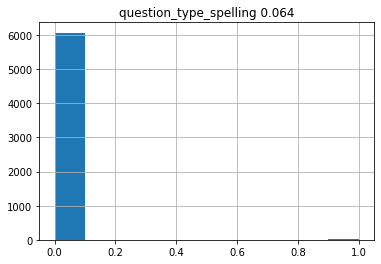

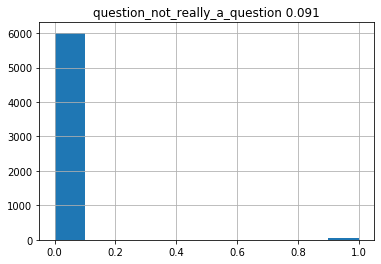

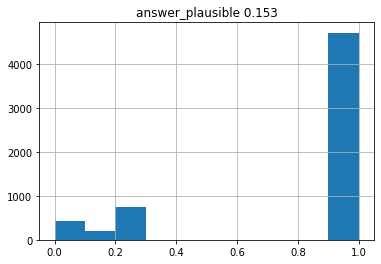

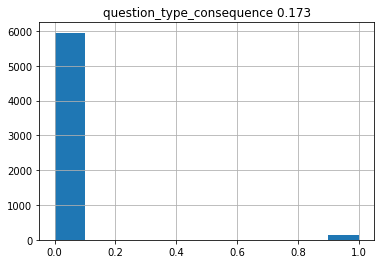

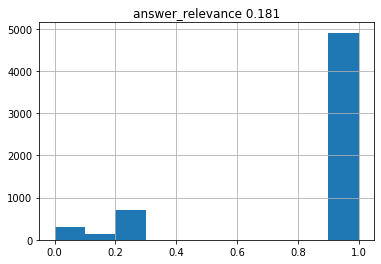

In [78]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


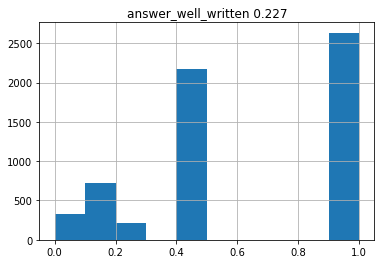

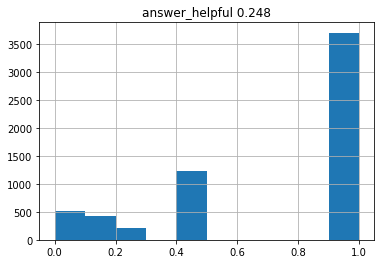

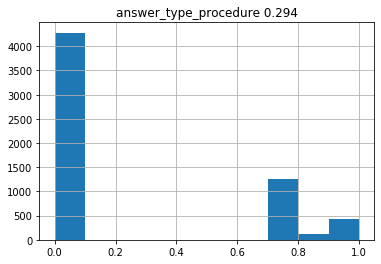

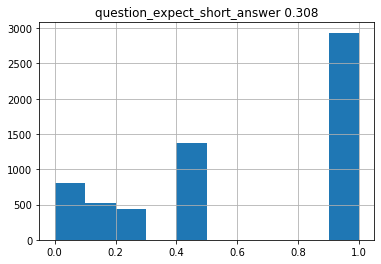

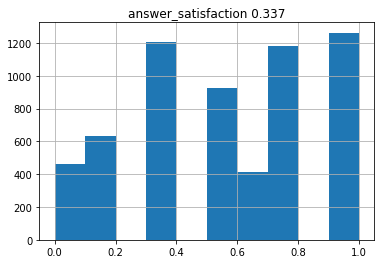

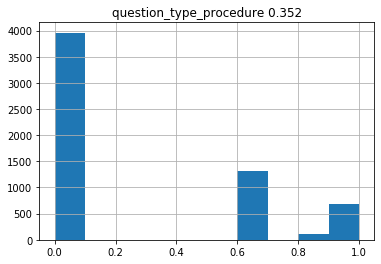

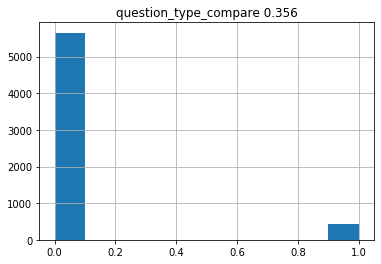

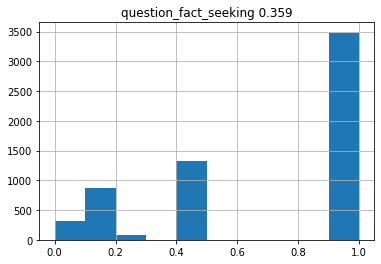

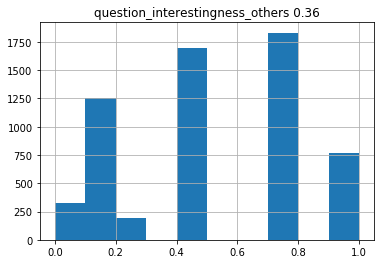

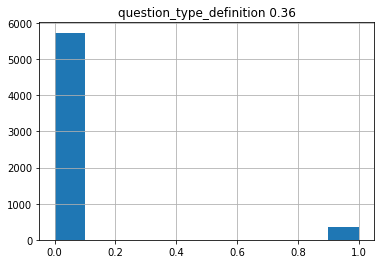

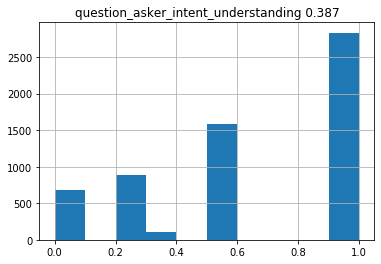

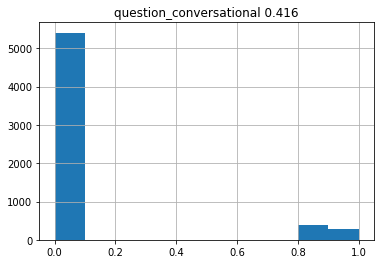

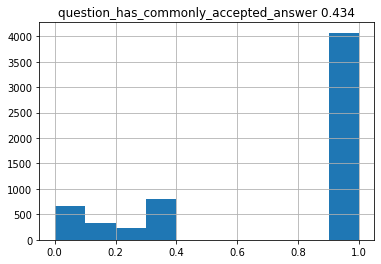

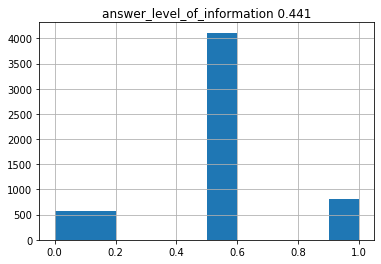

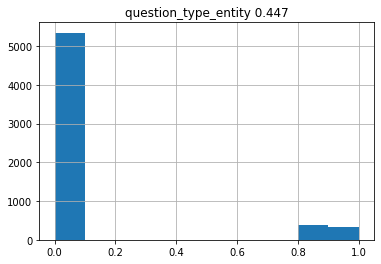

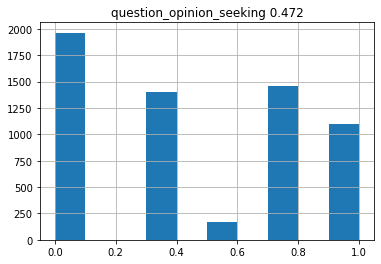

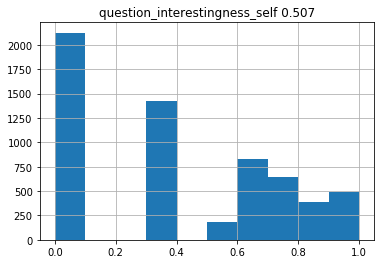

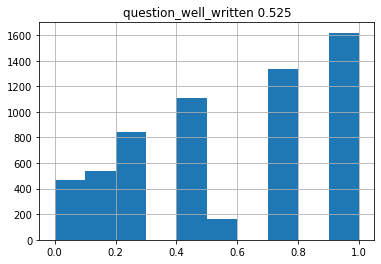

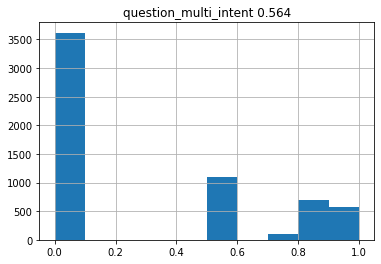

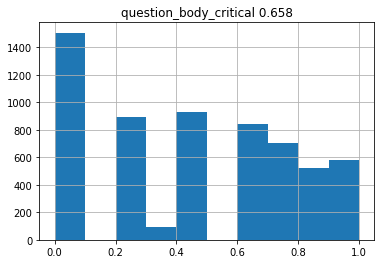

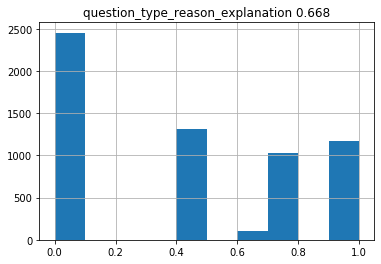

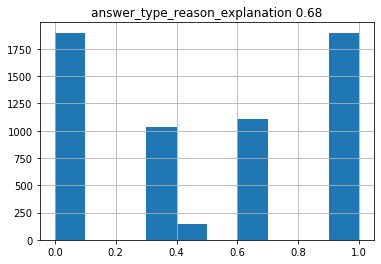

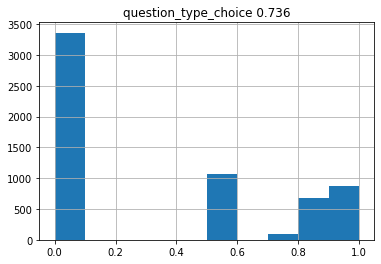

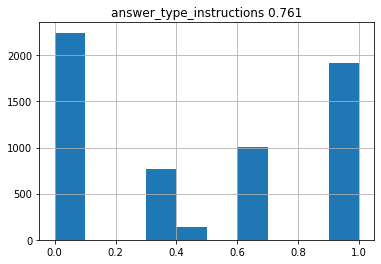

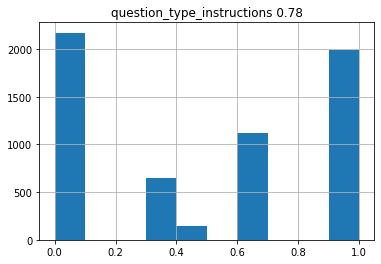

In [73]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')